In [ ]:
import dill
# dill.dump_session("citeseq_session.db")
dill.load_session("citeseq_session.db")

In [ ]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.spatial.distance import pdist,squareform

# Reprocessing CITESeq

## Importing Data

In [ ]:
# Source paper:
# https://www.nature.com/articles/nmeth.4380.pdf?origin=ppub

# Data is available on GEO, at GSE100866
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100866

In [ ]:
# Loading 

# Numpy facilities for loading csvs are kind of dumb, so we count the number of columns in the target

# columns = !head -n 1 ../../raw_data/citeseq/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv | grep -o ',' | wc -l
# columns = int(columns[0]) 

# rows = !wc -l ../../raw_data/citeseq/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv 
# rows = int(rows[0].split()[0]) - 1

columns = !head -n 1 ../../raw_data/citeseq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv | grep -o ',' | wc -l
columns = int(columns[0]) 

rows = !wc -l ../../raw_data/citeseq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv
rows = int(rows[0].split()[0]) - 1


print(f"Rows: {rows}, Columns: {columns}")


In [ ]:
umi_counts = np.zeros((rows,columns),dtype=int)


In [ ]:
# with open('../../raw_data/citeseq/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv') as file:
with open('../../raw_data/citeseq/GSE100866_PBMC_vs_flow_10X-RNA_umi.csv') as file:
    file.seek(0)
    lines = []
    while True:
        try:
            line = file.readline()
            if len(line) < 1:
                break
            lines.append(line)
#             print(len(lines))
        except:
            break

            


In [ ]:
for i,line in enumerate(lines[1:]):
#     print(i)
    split = [int(x) for x in line.split(',')[1:]]
    umi_counts[i] = np.array(split)

In [ ]:
gene_header = []

for i,line in enumerate(lines[1:]):
#     print(i)
    gene_header.append(line.split(',')[0].strip("\""))
    
gene_header = np.array(gene_header)

In [ ]:
rna_cell_header = [id.strip("\"\n") for id in lines[0].split(',')[1:]]
rna_cell_header

In [ ]:
# Saving the separated files in a numpy-friendly format

# np.savetxt('../../raw_data/citeseq/GSE100866_CBMC_umi_counts.tsv',umi_counts,fmt='%i')
# np.savetxt('../../raw_data/citeseq/GSE100866_CBMC_gene_header.tsv',gene_header,fmt='%s')

np.savetxt('../../raw_data/citeseq/GSE100866_PBMC_umi_counts.tsv',umi_counts,fmt='%i')
np.savetxt('../../raw_data/citeseq/GSE100866_PBMC_gene_header.tsv',gene_header,fmt='%s')


In [ ]:
# with open('../../raw_data/citeseq/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv') as file:
with open('../../raw_data/citeseq/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv') as file:
    file.seek(0)
    lines = []
    while True:
        try:
            line = file.readline()
            if len(line) < 1:
                break
            lines.append(line)
#             print(len(lines))
        except:
            break


In [ ]:
fluorescence_cell_header = [id.strip("\"\n") for id in lines[0].split(',')[1:]]
fluorescence_cell_header

In [ ]:
fluorescence_umis = np.zeros((len(lines)-1,columns))

for i,line in enumerate(lines[1:]):
#     print(i)
    split = [int(x) for x in line.split(',')[1:]]
    fluorescence_umis[i] = np.array(split)

In [ ]:
fluorescence_header = []

for i,line in enumerate(lines[1:]):
#     print(i)
    fluorescence_header.append(line.split(',')[0].strip("\""))
    
fluorescence_header = np.array(fluorescence_header)

In [ ]:
fluorescence_header

In [ ]:
# np.savetxt('../../raw_data/citeseq/GSE100866_CBMC_fluorescence_umis.tsv',fluorescence_umis,fmt='%i')
# np.savetxt('../../raw_data/citeseq/GSE100866_CBMC_fluorescence_header.tsv',fluorescence_header,fmt='%s')

np.savetxt('../../raw_data/citeseq/GSE100866_PBMC_fluorescence_umis.tsv',fluorescence_umis,fmt='%i')
np.savetxt('../../raw_data/citeseq/GSE100866_PBMC_fluorescence_header.tsv',fluorescence_header,fmt='%s')

In [ ]:
## Here we check just in case that rna and fluorescence cell headers are identical. All good.

fluorescence_cell_header == rna_cell_header

In [ ]:
np.savetxt('../../raw_data/citeseq/GSE100866_PBMC_cell_header.tsv',rna_cell_header,fmt='%s')

In [ ]:
### Only applicable to CBMC

# Finally CCR7 is not actually present (all values 0), so let's truncate 

# fluorescence_umis = fluorescence_umis[:13]
# fluorescence_header = fluorescence_header[:13]

In [ ]:
## In case we need to reload, after clearing the string objects from memory:

umi_counts = np.loadtxt('../../raw_data/citeseq/GSE100866_PBMC_umi_counts.tsv')
fluorescence_umis = np.loadtxt('../../raw_data/citeseq/GSE100866_PBMC_fluorescence_umis.tsv')

gene_header = np.loadtxt('../../raw_data/citeseq/GSE100866_PBMC_gene_header.tsv',dtype=str)
fluorescence_header = np.loadtxt('../../raw_data/citeseq/GSE100866_PBMC_fluorescence_header.tsv',dtype=str)

## Paring Down Data To Relevant Elements

In [ ]:
# First we will need to interpret umi counts as normalized expression values. Many approaches are used here

# The source paper performed extremely basic normalization without deconvolution or distribution compensation
# This is fine for a preliminary analysis, I don't feel like importing stuff so let's keep it basic:

umi_sums = np.sum(umi_counts,axis=0)

log_size_normalized = np.log10(umi_counts*10000 / np.tile(umi_sums,(umi_counts.shape[0],1)))
log_size_normalized[umi_counts == 0] = 0

In [ ]:
# We want to check how many genes are meaningfully expressed in the data set,
# and how variant they are:


means = np.mean(log_size_normalized,axis=1)
variance = np.var(log_size_normalized,axis=1)

mean_ranking = np.argsort(means)
variance_ranking = np.argsort(variance)

plt.figure()
plt.title("Means Vs Variance For All Genes")
plt.scatter(means,variance,s=1)
plt.xlabel("Means")
plt.ylabel("Variances")
plt.show()

plt.figure()
plt.title("Mean-ranked Variance")
plt.scatter(np.arange(5000),variance[mean_ranking[-5000:]],s=1,c=means[mean_ranking[-5000:]],cmap='binary')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Sparsity")
plt.scatter(np.arange(20000),(np.sum(umi_counts > 0,axis=1)/umi_counts.shape[1])[mean_ranking[-20000:]],s=1)
plt.show()

Here we notice that there are two distinct apparent populations of genes. We recall that the source paper spiked in mouse genetic material, and we would like to eliminate the mouse genes from further analysis:

In [ ]:
### PBMC:
#Mouse genes appear after position 17014 in the gene header.
print(list(gene_header[:17014]))


### CBMC:
# Mouse genes appear after position 20401 in the gene header.
# print(list(gene_header[:20401]))

In [ ]:
human_normalized = log_size_normalized[:17014]
human_gene_header = gene_header[:17014]

# human_normalized = log_size_normalized[:20401]
# human_gene_header = gene_header[:20401]

In [ ]:
# We also want to eliminate mouse cells from the analysis (we can examine them later if needed)
# The source paper uses a criterion that more than 90% of UMIs in a cell must be aligned to human genes for a cell to be 
# considered human, so let's stick with that. 

umi_sums = np.sum(umi_counts,axis=0)
umi_sums.shape

umi_human_gene_sums = np.sum(umi_counts[:17014],axis=0)

human_fraction = umi_human_gene_sums/umi_sums

human_mask = human_fraction > .9

print(np.sum(human_mask))

plt.figure()
plt.hist(umi_human_gene_sums,bins=50)
plt.show()

plt.figure()
plt.hist(umi_sums,bins=50)
plt.show()

plt.figure()
plt.hist(human_fraction,bins=50)
plt.show()


In [ ]:
human_normalized = human_normalized.T[human_mask].T
fluorescence_umis = fluorescence_umis.T[human_mask].T

In [ ]:
# Rerunning earlier analysis


means = np.mean(human_normalized,axis=1)
variance = np.var(human_normalized,axis=1)

mean_ranking = np.argsort(means)
variance_ranking = np.argsort(variance)

plt.figure()
plt.title("Means Vs Variance For All Genes")
plt.scatter(means,variance,s=1)
plt.xlabel("Means")
plt.ylabel("Variances")
plt.show()

plt.figure()
plt.title("Mean-ranked Variance")
plt.scatter(np.arange(5000),variance[mean_ranking[-5000:]],s=1,c=means[mean_ranking[-5000:]],cmap='binary')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Variance-ranked Variance")
plt.scatter(np.arange(5000),variance[variance_ranking[-5000:]],s=1,c=means[variance_ranking[-5000:]],cmap='binary')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Sparsity")
plt.scatter(np.arange(5000),(np.sum(umi_counts[:20401] > 0,axis=1)/umi_counts[:20401].shape[1])[mean_ranking[-5000:]],s=1)
plt.show()

In [ ]:
## We also want to examine the coefficient of variance to look at genes that may meaningfully contribute to differentiation 

cov = means[variance_ranking[-5000:]] / variance[variance_ranking[-5000:]]

plt.figure()
plt.title("CoV for top genes")
plt.scatter(np.arange(5000),cov,s=1)
plt.show()

In all likelihood we are safe in paring down the output to only the top 2000 most variant genes. This will probably leave out transcription factors and the like, but... vOv

In [ ]:
truncated_counts = human_normalized[variance_ranking[-2000:]].T
header = human_gene_header[variance_ranking[-2000:]]

# truncated_counts = human_normalized[mean_ranking[-7000:]].T
# header = human_gene_header[mean_ranking[-7000:]]

from sklearn.preprocessing import scale

counts = scale(truncated_counts)

print(counts.shape)
print(header.shape)

In [ ]:
# Let's normalize the antibody derived tags as well
# Source paper calls for normalization via Centered Log Ratio

from scipy.stats.mstats import gmean

f_gmeans = gmean(fluorescence_umis+1,axis=0)
# f_gmeans
fluorescence_counts = np.log((fluorescence_umis + 1) / np.tile(f_gmeans,(fluorescence_umis.shape[0],1)))



In [ ]:
np.savetxt("citeseq_counts.tsv",counts)
np.savetxt("citeseq_adt.tsv",fluorescence_counts)
np.savetxt("citeseq_header.txt",header,fmt='%s')
np.savetxt("citeseq_fluorescence_header.tsv",fluorescence_header,fmt='%s')

In [ ]:
import numpy as np

# counts = np.loadtxt('../../raw_data/citeseq_counts.tsv')
# fluorescence_counts = np.loadtxt('../../raw_data/citeseq_adt.tsv')
# header = np.loadtxt('../../raw_data/citeseq_header.txt',dtype=str)
# fluorescence_header = np.loadtxt('../../raw_data/citeseq_fluorescence_header.txt',dtype=str)
counts = np.loadtxt('citeseq_counts.tsv')
fluorescence_counts = np.loadtxt('citeseq_adt.tsv')
header = np.loadtxt('citeseq_header.txt',dtype=str)
fluorescence_header = np.loadtxt('citeseq_fluorescence_header.tsv',dtype=str)

## Processing Data

In [ ]:
# First let's take a quick look at the fluorescence and genetic expression data

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
fluorescence_coordinates = TSNE().fit_transform(fluorescence_counts.T)

plt.figure()
plt.title("TSNE Manifold Mapping of Fluorescence Values for Blood Cells")
plt.scatter(fluorescence_coordinates.T[0],fluorescence_coordinates.T[1],s=1)
plt.show()

In [ ]:
gene_coordinates = TSNE().fit_transform(PCA(n_components=20).fit_transform(counts))
# gene_coordinates = TSNE(metric='cosine').fit_transform(counts)


plt.figure()
plt.title("TSNE Manifold Mapping of PCA Decomposed Gene Expression Values, Blood Cells ")
plt.scatter(gene_coordinates.T[0],gene_coordinates.T[1],s=1)
plt.show()

In [ ]:
# Now we need to recreate the canonical labels based on antibody surface markers. We have markers as follows:
print(fluorescence_header)

In [ ]:
# Agglomerative clustering is also going to be a helpful way of looking at the data:

from scipy.cluster.hierarchy import dendrogram,linkage

feature_sort = dendrogram(linkage(counts.T,metric='cosine',method='average'),no_plot=True)['leaves']
sample_sort = dendrogram(linkage(counts,metric='cosine',method='average'),no_plot=True)['leaves']
fluorescence_sort = dendrogram(linkage(fluorescence_counts,method='average'),no_plot=True)['leaves']

plt.figure(figsize=(20,20))
plt.imshow(counts[sample_sort].T[feature_sort].T,cmap='bwr',aspect='auto')
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(np.log10(1 + fluorescence_counts.T[sample_sort]),aspect='auto')
plt.colorbar()
plt.show()

In [ ]:

# We can map cell surface markers to cell identities using refernce literature like the BD cell surface marker handbook:
# https://www.bdbiosciences.com/documents/cd_marker_handbook.pdf

# A basic mapping would be:

# CD3   + ::: T Cells
# CD2   + ::: T/B/NK (Adhesion)
# CD4   + ::: Granular cells (T, Macro, Granulo, early phase)

# CD8   + ::: T/NK (unclear since handbook lists 2 variants)
# CD45  + ::: T/B cell differentiation (not erythrocyte)

# CD56  + ::: T and NK (adhesion)
# CD57  + ::: T and NK (adhesion)
# CD16  + ::: T, Dendritic, NK, Macro, Granulo (IgG binding)
# CD10  + ::: NK, Endothelial 

# CD11c + ::: General marker (inflammatory response?)
# CD14  + ::: LPS response, Macrophage, Granulocyte


# CD19  + ::: B Cell, Dendritic, Stem marker
# CD34  + ::: Stem Cells, Endothelial 
# CCR5  + ::: Migration (T, Macro, Gran)
# CCR7  + ::: T/B/Dend


In [ ]:
# We would like to cluster the cells, then examine the fluorescence value of each marker in each cluster

print(fluorescence_header)

In [ ]:
plt.figure()
plt.title("All Cells")
plt.scatter(fluorescence_counts[9],fluorescence_counts[0],s=1)
plt.xlabel("CD19 (TPM)")
plt.ylabel("CD3 (TPM)")
plt.show()

In [ ]:
cd3_p_mask = fluorescence_counts[0] > 1.2
cd19_p_mask = fluorescence_counts[9] > 1

t_mask = np.logical_and(cd3_p_mask,np.logical_not(cd19_p_mask))
b_mask = np.logical_and(cd19_p_mask,np.logical_not(cd3_p_mask))

In [ ]:
plt.figure()
plt.title("All Cells")
plt.scatter(fluorescence_counts[9],fluorescence_counts[0],s=1,c=b_mask)
plt.xlabel("CD19")
plt.ylabel("CD3")
plt.show()

In [ ]:
# Now we'd like to differentiate between CD4 and CD8 T cells:

plt.figure()
plt.title("T Cells only (CD3+,CD19-)")
plt.scatter(fluorescence_counts[2][t_mask],fluorescence_counts[1][t_mask],s=1)
plt.xlabel("CD8A")
plt.ylabel("CD4")
plt.show()

cd4_t = np.logical_and(t_mask,np.logical_and(fluorescence_counts[1] > 0,fluorescence_counts[2] < 1.5))
cd8_t = np.logical_and(t_mask,np.logical_and(fluorescence_counts[1] < 0,fluorescence_counts[2] > 3))

plt.figure()
plt.title("T Cells only (CD3+,CD19-)")
plt.scatter(fluorescence_counts[2][t_mask],fluorescence_counts[1][t_mask],c=cd4_t[t_mask],s=1)
plt.xlabel("CD8A")
plt.ylabel("CD4")
plt.show()

plt.figure()
plt.title("T Cells only (CD3+,CD19-)")
plt.scatter(fluorescence_counts[2][t_mask],fluorescence_counts[1][t_mask],c=cd8_t[t_mask],s=1)
plt.xlabel("CD8A")
plt.ylabel("CD4")
plt.show()


In [ ]:
## Now let's examine how these are distributed in the TSNE:

plt.figure()
plt.title("TSNE Manifold Mapping of PCA Decomposed Gene Expression Values, CD4+ T Cells Colored, Blood Cells ")
plt.scatter(gene_coordinates.T[0],gene_coordinates.T[1],c=cd4_t,s=1)
plt.show()

In [ ]:
plt.figure()
plt.title("TSNE Manifold Mapping of PCA Decomposed Gene Expression Values, CD8+ T Cells Colored, Blood Cells ")
plt.scatter(gene_coordinates.T[0],gene_coordinates.T[1],c=cd8_t,s=1)
plt.show()

In [ ]:
## Finally let's try to map out naive, memory, and effector cells

plt.figure()
plt.title("CD4 T Cells")
plt.scatter(fluorescence_counts[3][cd4_t],fluorescence_counts[5][cd4_t],s=1)
plt.xlabel("CD2")
plt.ylabel("CD57")
plt.show()

plt.figure()
plt.title("CD8 T Cells")
plt.scatter(fluorescence_counts[3][cd8_t],fluorescence_counts[5][cd8_t],s=1)
plt.xlabel("CD2")
plt.ylabel("CD57")
plt.show()

cd4_t_naive = np.logical_and(cd4_t,np.logical_and(fluorescence_counts[3] < 2.5,fluorescence_counts[5] < 1))
cd4_t_57_effector = np.logical_and(cd4_t,fluorescence_counts[5] > 1)
cd4_t_memory = np.logical_and(cd4_t,np.logical_and(fluorescence_counts[3] > 2.5,fluorescence_counts[5] < 1))

cd8_t_naive = np.logical_and(cd8_t,np.logical_and(fluorescence_counts[3] < 2.5,fluorescence_counts[5] < 1))
cd8_t_57_effector = np.logical_and(cd8_t,fluorescence_counts[5] > 1)
cd8_t_memory = np.logical_and(cd8_t,np.logical_and(fluorescence_counts[3] > 2.5,fluorescence_counts[5] < 1))


In [ ]:
plt.figure()
plt.title("CD4 T Cells")
plt.scatter(fluorescence_counts[3][cd4_t],fluorescence_counts[5][cd4_t],c=cd4_t_57_effector[cd4_t],s=1)
plt.xlabel("CD2")
plt.ylabel("CD57")
plt.show()

plt.figure()
plt.title("CD8 T Cells")
plt.scatter(fluorescence_counts[3][cd8_t],fluorescence_counts[5][cd8_t],c=cd8_t_57_effector[cd8_t],s=1)
plt.xlabel("CD2")
plt.ylabel("CD57")
plt.show()


In [ ]:
fc = forest.coordinates()

plt.figure()
plt.scatter(fc[:,0],fc[:,1],s=1,c=cd4_t_naive)
plt.show()

## Forest Analysis

In [1]:
import sys
sys.path.append("../src/")
import lumberjack
import tree_reader_sc as tr

In [2]:
# forest = lumberjack.fit(input_counts=counts,output_counts=counts,header=header,ifs=400,ofs=400,ss=400,trees=50,depth=5,norm='l1')

In [3]:
# forest.backup('citeseq_forest_l1')
# forest.backup('citeseq_forest_l1_cache')

In [4]:
# !ls -lh

In [5]:
forest = tr.Forest.reconstitute('citeseq_forest_l1_cache')
# forest = tr.Forest.reconstitute('citeseq_forest')
# forest = tr.Forest.reconstitute('citeseq_forest_cache')

In [6]:
forest.reset_output_featuers()

Removing:['sample_cluster_0' 'sample_cluster_1' 'sample_cluster_2'
 'sample_cluster_3' 'sample_cluster_4' 'sample_cluster_5'
 'sample_cluster_6' 'sample_cluster_7' 'sample_cluster_8'
 'sample_cluster_9' 'sample_cluster_10' 'sample_cluster_11'
 'sample_cluster_12' 'sample_cluster_13' 'sample_cluster_14'
 'sample_cluster_15' 'sample_cluster_16' 'sample_cluster_17'
 'sample_cluster_18' 'sample_cluster_19' 'sample_cluster_20'
 'sample_cluster_21' 'sample_cluster_22' 'sample_cluster_23']


In [7]:
# forest.set_cache(True)

In [8]:
## First we must find common marginal effects of splits in the random forest.
# We can do this by clustering vectors representing the marginal effect of each split

# forest.reset_clusters()
# forest.interpret_splits(depth=5,mode='additive',sub=.5,metric='cosine',k=10,pca=False,override=False)

## TO DO: REDO DEFAULTS

['HUMAN_GDI2' 'HUMAN_COX6C' 'HUMAN_NDUFA1' ... 'HUMAN_RPL27' 'HUMAN_SPI1'
 'HUMAN_PYCARD']
[-6.51244327 -6.00868734 -4.75377326 ...  5.09639811  5.27963917
  5.6362306 ]


../src/tree_reader_sc.py:1643: RuntimeWarning: invalid value encountered in log2
  log_fold_change = np.log2(n2_medians/n1_medians)


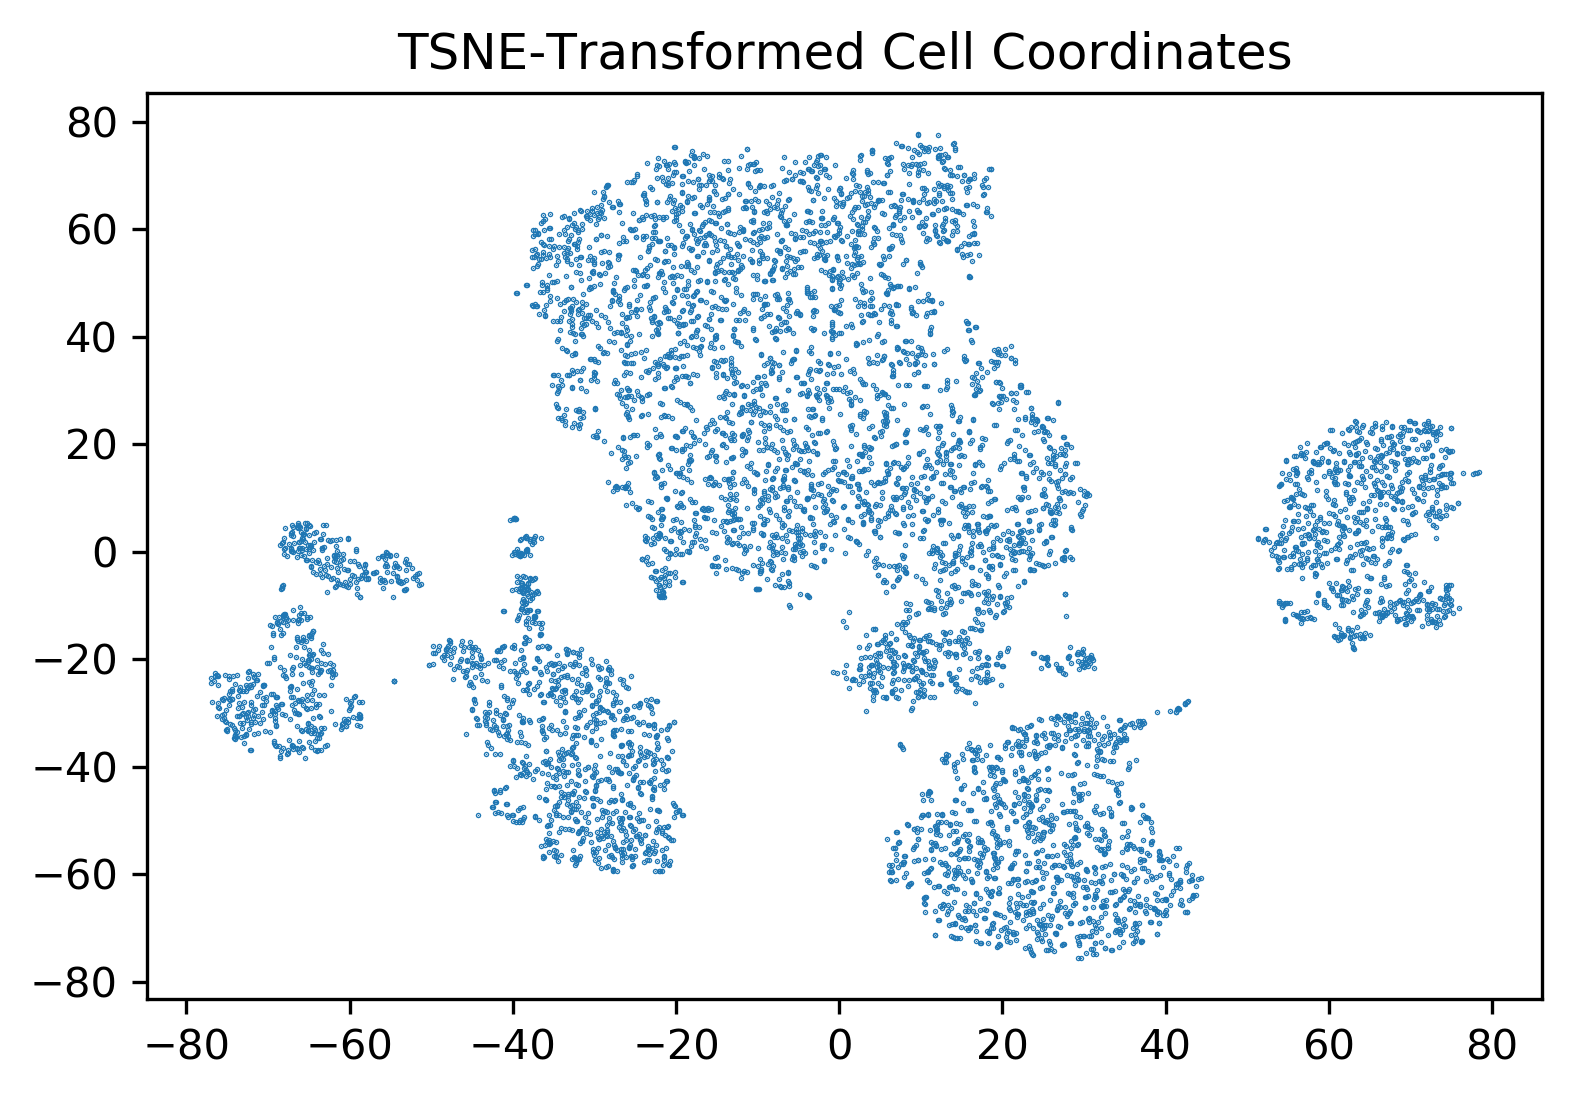

/Users/boris/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/boris/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


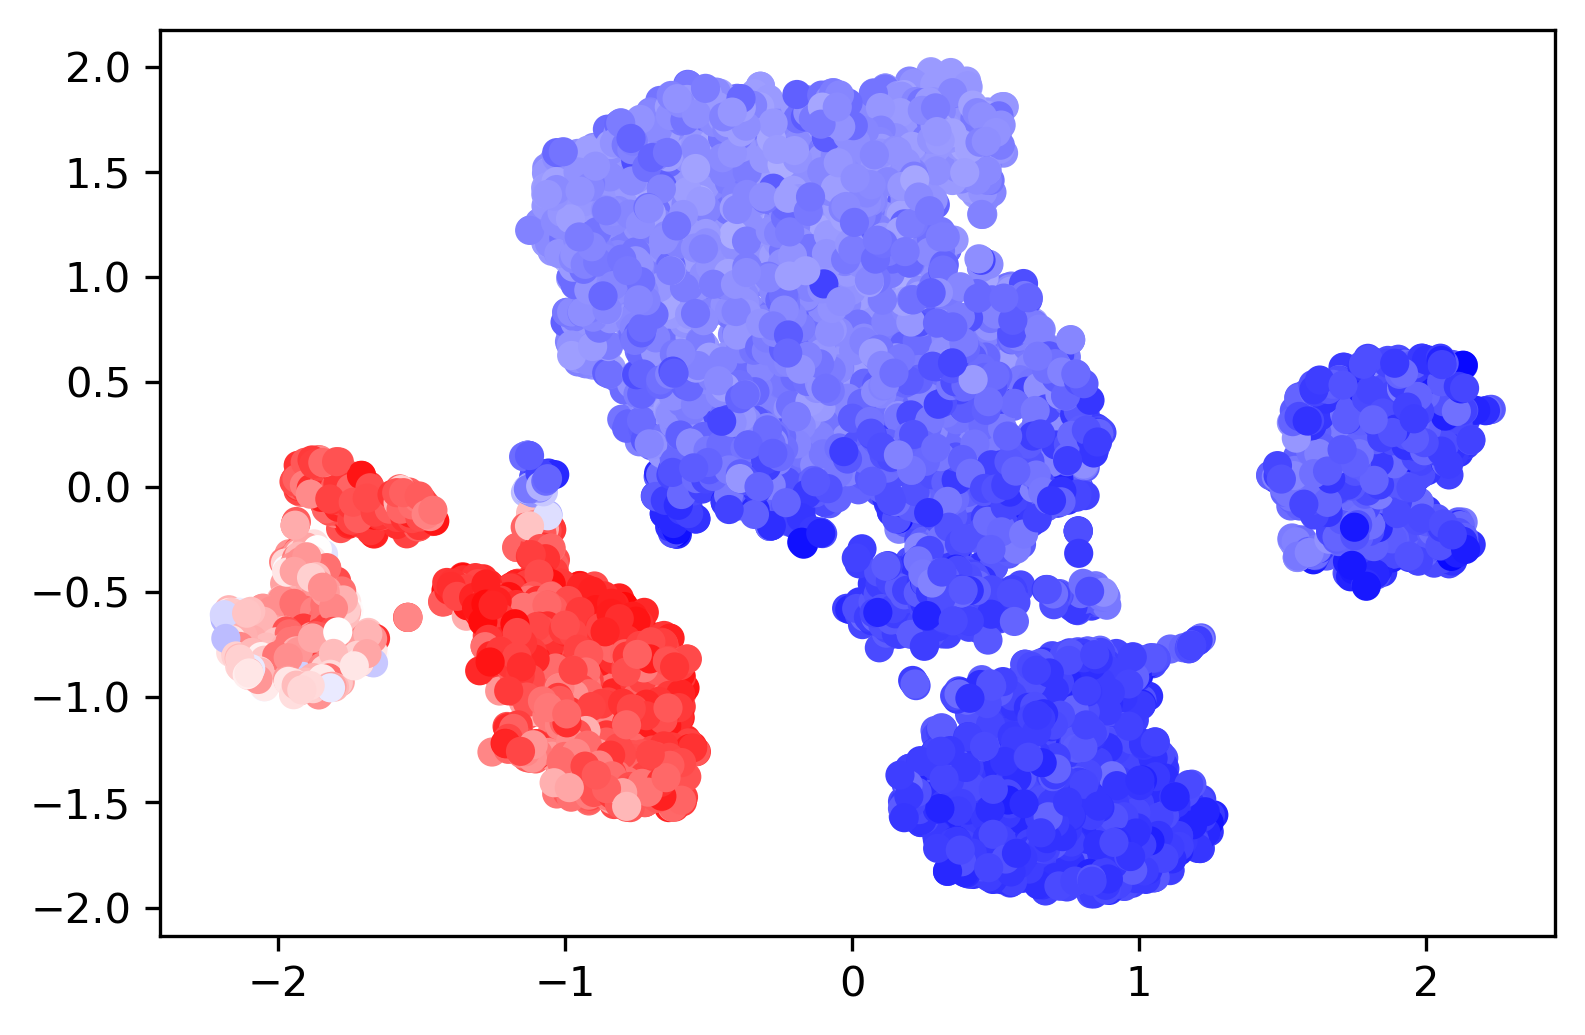

In [9]:
## Placeholder debugging cell
# forest.plot_tree_summary(figsize=(30,10),type='additive_features',features=forest.output_features[1990:2000],cmap='bwr')
# print(forest.split_clusters[0].css_additive_panel(features=forest.output_features[1990:2000]))
forest.split_clusters[1].html_cluster_summary()

In [ ]:
forest.dependence_tree()

In [ ]:
## We want to examine the common splits in two ways: 

# Cell populations they affect and effects of each split

forest.plot_tree_summary(figsize=(20,6),type='score')

In [ ]:

tc = forest.coordinates(no_plot=True)

for split_cluster in forest.split_clusters:
    print(split_cluster.id)
    try:
        print(sorted(list(split_cluster.braid_features().items()),key=lambda x:x[1])[::-1])
#         print(list(split_cluster.braid_features().items()))
    except:
        pass
#     split_cluster.plot_cell_counts()
#     cell_score = split_cluster.cell_counts()

#     f = plt.figure(figsize=(15,10))
#     plt.title("Cell Score")
#     plt.scatter(tc[:,0],tc[:,1],c=cell_score)
#     plt.colorbar()
#     plt.show()
    
    sister_color = split_cluster.sister_scores()

    f = plt.figure(figsize=(15,10))
    plt.title("Sister Split")
    plt.scatter(tc[:,0],tc[:,1],c=sister_color,cmap='bwr',vmin=max(sister_color)*-1)
    plt.colorbar()
#     plt.show()
    plt.savefig(f"ss{split_cluster.id}.png")

In [ ]:
# forest.cluster_samples_simple(sub=.5,k=20,pca=20,metric='cosine',override=True)
forest.cluster_samples_encoding(sub=.3,metric='cosine',k=20,override=True,pca=20)
len(forest.sample_clusters)

In [ ]:
forest.plot_cell_clusters()

In [ ]:
plt.figure()
plt.title("TSNE Manifold Mapping of Fluorescence Values for Blood Cells")
plt.scatter(fluorescence_coordinates.T[0],fluorescence_coordinates.T[1],s=1,c=forest.sample_labels,cmap='rainbow')
plt.show()

In [ ]:
# from scipy.cluster.hierarchy import dendrogram,linkage

feature_sort = dendrogram(linkage(counts.T,metric='cosine',method='average'),no_plot=True)['leaves']
sample_sort = np.argsort(forest.sample_labels)

plt.figure(figsize=(20,20))
plt.imshow(counts[sample_sort].T[feature_sort].T,cmap='bwr',aspect='auto')
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(fluorescence_counts.T[sample_sort],aspect='auto')
plt.xticks(np.arange(10),fluorescence_header)
plt.show()


In [ ]:
fluorescence_counts.shape

In [ ]:
sample_cluster_features = forest.sample_cluster_feature_matrix()
sample_cluster_sort = dendrogram(linkage(sample_cluster_features,metric='cosine',method='average'),no_plot=True)['leaves']


plt.figure(figsize=(20,20))
plt.imshow(sample_cluster_features[sample_cluster_sort].T[feature_sort].T,cmap='bwr',aspect='auto')
plt.yticks(np.arange(len(forest.sample_clusters)),np.arange(len(forest.sample_clusters))[sample_cluster_sort])
plt.show()


In [ ]:
# focused = sample_cluster_features[sample_cluster_sort].T[feature_sort].T[-4:]
# feature_resort = dendrogram(linkage(focused.T,metric='cosine',method='average'),no_plot=True)['leaves']

# plt.figure(figsize=(20,5))
# plt.imshow(focused,cmap='bwr',aspect='auto')
# plt.show()

# plt.figure(figsize=(5,30))
# plt.imshow(focused.T[feature_resort],cmap='bwr',aspect='auto')
# plt.show()


In [ ]:
t_markers = np.array([
    b_mask,
    t_mask,
    cd4_t,
    cd8_t,
    cd4_t_naive,
    cd4_t_memory,
    cd4_t_57_effector,
    cd8_t_naive,
    cd8_t_memory,
    cd8_t_57_effector])

t_marker_header = [
    "b_cell",
    "t_cell",
    "cd4_t_cell",
    "cd8_t_cell",
    "cd4_t_naive",
    "cd4_t_memory",
    "cd4_t_effector",
    "cd8_t_naive",
    "cd8_t_memory",
    "cd8_t_effector",
]

# t_markers.shape

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(t_markers.T[sample_sort],aspect='auto')
plt.xticks(np.arange(10),fluorescence_header)
plt.show()


In [ ]:
## We would now like to see what kind of distribution there is between forest splits and sample clusters
# for the fluorescence features

fluorescence_features = list(fluorescence_header) + list(t_marker_header)
fluorescence_feature_values = np.array([f for f in fluorescence_counts[:-1]] + [m for m in t_markers])

print(fluorescence_features)
print(len(fluorescence_features))
print(fluorescence_feature_values.shape)

for feature,feature_values in zip(fluorescence_features,fluorescence_feature_values):
    forest.add_output_feature(feature_values,feature)

In [ ]:
forest.output_features[2000:]

In [ ]:
sample_cluster_fluorescence = forest.sample_cluster_feature_matrix(fluorescence_features)
# print(sample_cluster_fluorescence.shape)

plt.figure(figsize=(20,20))
plt.imshow(sample_cluster_fluorescence[:,10:],aspect='auto')
plt.yticks(np.arange(len(forest.sample_clusters)),np.arange(len(forest.sample_clusters)))
plt.xticks(np.arange(10),fluorescence_features[10:])
plt.colorbar()
plt.show()

# plt.figure(figsize=(20,20))
# plt.imshow(sample_cluster_fluorescence[sample_cluster_sort],aspect='auto')
# plt.yticks(np.arange(23),np.arange(23)[sample_cluster_sort])
# plt.xticks(np.arange(20),fluorescence_features)
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(20,20))
# plt.imshow(sample_cluster_fluorescence[sample_cluster_sort][:,:10],aspect='auto')
# plt.yticks(np.arange(23),np.arange(23)[sample_cluster_sort])
# plt.xticks(np.arange(10),fluorescence_features[:10])
# plt.colorbar()
# plt.show()

plt.figure(figsize=(20,20))
plt.imshow(sample_cluster_fluorescence[sample_cluster_sort][:,10:],aspect='auto')
plt.yticks(np.arange(len(forest.sample_clusters)),np.arange(len(forest.sample_clusters))[sample_cluster_sort])
plt.xticks(np.arange(10),fluorescence_features[10:])
plt.colorbar()
plt.show()


In [ ]:
forest.likely_tree

In [ ]:
def flatten_tree(tree):
    flat = []
    for child in tree[1]:
        flat.extend(flatten_tree(child))
    flat.append([tree[0],[c[0] for c in tree[1]]])
    return flat

def levels(tree,level=0):
    l = []
    for child in tree[1]:
        l.extend(levels(child,level=level+1))
    l.append(level)
    return l

flat = flatten_tree(forest.likely_tree)

flat_label = [f[0] for f in flat]

In [ ]:
print(flat)
print(flat_label)
print(np.arange(25)[flat_label])

In [ ]:
split_cluster_fluorescence = forest.split_cluster_feature_matrix(fluorescence_features)
split_cluster_fluorescence.shape

In [ ]:
# plt.figure(figsize=(20,20))
# plt.imshow(split_cluster_fluorescence[:,10:],aspect='auto')
# plt.yticks(np.arange(21),np.arange(21))
# plt.xticks(np.arange(10),fluorescence_features[:10])
# plt.colorbar()
# plt.show()

plt.figure(figsize=(20,20))
plt.imshow(split_cluster_fluorescence[flat_label][:,10:],aspect='auto')
plt.yticks(np.arange(21),flat_label)
plt.xticks(np.arange(10),fluorescence_features[10:])
plt.colorbar()
plt.show()

In [ ]:
def flat_linkage(tree):
    flat_tree = flatten_tree(tree)
    print(flat_tree)
    node_translation = {n[0]:i for i,n in enumerate(flat_tree)}
    print(node_translation)
    node_levels = levels(tree)
    
    coordinates = np.zeros((len(flat_tree),2))
    
    coordinates[:,1] = np.arange(len(flat_tree),0,-1)
    coordinates[:,0] = node_levels
    
    coordinates[:,1] /= np.max(coordinates[:,1])
    coordinates[:,0] /= np.max(coordinates[:,0])
    
    links = []
    
    for node in flat_tree:
        node_index = node_translation[node[0]]
        for child in (node[1]):
            child_index = node_translation[child]
            links.append(([node[0],child],[coordinates[node_index,0],coordinates[child_index,0]],[coordinates[node_index,1],coordinates[child_index,1]]))
    return links

In [ ]:
flat_linkage(forest.likely_tree)

In [ ]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
links = flat_linkage(forest.likely_tree)
for i,link in enumerate(links):
#     ax1.scatter(link[2][0],link[2][1])
    print(link[1][0],link[1][1],link[0][0],link[0][1])
    ax1.text(link[1][1] + .1 ,link[2][1],s=link[0][1],verticalalignment='center',horizontalalignment='center')
for i,link in enumerate(links):
    ax1.plot(link[1],link[2])
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
ax2.imshow(split_cluster_fluorescence[flat_label][:,10:],aspect='auto')
ax2.set_yticks(np.arange(21))
ax2.set_yticklabels(flat_label)
ax2.set_xticks(np.arange(10))
ax2.set_xticklabels(fluorescence_features[10:],rotation=45,verticalalignment='top',horizontalalignment='right')
fig.show()


In [ ]:
ff = [fluorescence_features[10],] + fluorescence_features[14:]
# ff
forest.plot_tree_summary(figsize=(20,5),type='features',features=ff,cmap='bwr')

In [ ]:
forest.plot_tree_summary(type='id')

In [ ]:
forest.plot_tree_summary()

In [ ]:
forest.plot_manifold()

In [ ]:
forest.plot_split_clusters()

In [ ]:
forest.coordinates(type='tsne',override=True)

In [ ]:
print(len(forest.sample_clusters))

In [ ]:
forest.likely_tree

In [ ]:
pd = forest.partial_dependence()
# direction = forest.directional_matrix()

plt.figure(figsize=(20,20))
plt.imshow(pd)
plt.show()

# plt.figure(figsize=(20,20))
# plt.imshow(direction)
# plt.show()

In [ ]:
np.argmin(pd,axis=1)

In [ ]:
forest.likely_tree

In [ ]:
forest.added_features = 43

In [ ]:
forest.reset_output_featuers()

In [ ]:
forest.output.shape

In [ ]:
forest.added_features

In [ ]:
forest.output.shape

In [ ]:
forest.reset_output_featuers()

In [ ]:
forest.reset_output_featuers()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
forest.split_clusters[4].feature_panel(ax,fluorescence_features)

In [ ]:
forest.reset_cache()

In [ ]:
def recursive_nested_css(tree,i=1):
    node_string = """\
    <div class="node-style",style="grid-column-begin:{};">
            <h1>{}</h1>
            {}
    </div>
    """.format(i,tree[0],"".join([recursive_nested_css(child,i+1) for i,child in enumerate(tree[1])]))
    
    return node_string

In [ ]:
toy_tree = [0,[[1,[]],[2,[]]]]
print(recursive_nested_css(toy_tree))

In [ ]:

def generate_node_feature_html(features,values,normalization=None,cmap=None):
    
    if cmap is None:
        from matplotlib.cm import get_cmap
        cmap = get_cmap('viridis')
    
    html_elements = [
        "<table>",
        "<style>","th,td {padding:5px;border-bottom:1px solid #ddd;}","</style>",
        "<tr>",
        "<th>","Features","</th>",
        "<th>","Values","</th>",
        "</tr>",
    ]
    for feature,value in zip(features,values):
        value_color_tag = ""
        if normalization is not None:
            normed_value = normalization(value)
            r,g,b,a = cmap(normed_value)
            r,g,b,a = r*100,g*100,b*100,a*100
            value_color_tag = f'style="background-color:rgba({r}%,{g}%,{b}%,50%);"'
        feature_elements = f"""
            <tr>
                <td>{feature}</td>
                <td {value_color_tag}>{value}</td>
            </td>
        """
        html_elements.append(feature_elements)
    
    html_elements.append("</table>")
    return "".join(html_elements)

In [ ]:
features = ["Hsp90","Klu"]
values = [1,.5]
vr = mpl.cm.get_cmap('viridis')
norm = mpl.colors.DivergingNorm(0)

In [ ]:
print(generate_node_feature_html(features,values,cmap=vr,normalization=norm))